## Mahan Mirza Khanlari -- Computational -- HW2

## Fixed Timestep

`kepler` computes the derivatives of the vector [x, y, v_x, v_y] for equations of motion.`rk4_step` is just our 4th-order Runge-Kutta.

`energy` calculates the total energy (KE+Potential), and `integrate_orbit` evolves the orbit for one year (one orbital period since a=1) using a fixed timestep. Then we compare the errors in the final position and the total energy for timesteps 1 month, 1 week,and 1 day. We do this for both a e=0 and e = 0.96.

*.copy() is used when initializing or updating the state so that each stored state is an independent snapshot.*

*np.linalg.norm() is simply the euclidean distance between the two points in a 2D space.*

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['font.family'] = 'serif'
plt.rcParams['mathtext.fontset'] = 'dejavuserif'
plt.rcParams['xtick.direction']= 'in'
plt.rcParams['ytick.direction']= 'in'
GM = 4 * np.pi**2 #gravitational constant in AU^3/yr^2

In [2]:
def kepler(t, y):
    """
    Kepler equations.
    y = [x, y, vx, vy]
    """
    x, y_pos, vx, vy = y
    r = np.sqrt(x**2 + y_pos**2)
    return np.array([vx, vy, -GM * x / r**3, -GM * y_pos / r**3])

In [3]:
def rk4_step(f, t, y, dt):
    """
    One RK4 step.
    """
    k1 = dt * f(t, y)
    k2 = dt * f(t + dt/2, y + k1/2)
    k3 = dt * f(t + dt/2, y + k2/2)
    k4 = dt * f(t + dt, y + k3)
    return y + (k1 + 2*k2 + 2*k3 + k4) / 6

In [4]:
def energy(state):
    """
    Total energy (KE + potential).
    """
    x, y_pos, vx, vy = state
    r = np.sqrt(x**2 + y_pos**2)
    return 0.5 * (vx**2 + vy**2) - GM / r

In [5]:
def integrate_orbit(dt, T=1, y0=None):
    """
    Fixed RK4 integration over time T.
    Returns the final position and energy errors.
    """
    if y0 is None:
        #default is a circular orbit (e = 0) with initial state [0, 1, -2π, 0]
        y0 = np.array([0, 1, -2*np.pi, 0])
    E0 = energy(y0)
    t = 0
    y = y0.copy()
    while t < T:
        #adjusting dt on the last step if needed
        if t + dt > T:
            dt = T - t
        y = rk4_step(kepler, t, y, dt)
        t += dt
    pos_error = np.linalg.norm(y[:2] - y0[:2])
    energy_error = abs(energy(y) - E0)
    return pos_error, energy_error

In [6]:
#parameters for an elliptical orbit
a = 1
e = 0.96
r_p = a * (1 - e)
v_p = np.sqrt(GM / a) * np.sqrt((1 + e) / (1 - e))
y0_ecc = np.array([0, r_p, -v_p, 0])
timesteps = {"1 month": 1/12,"1 week": 1/48,"1 day": 1/365.25}

In [7]:
print("e = 0 orbit:")
print()
for label, dt in timesteps.items():
    pos_err, E_err = integrate_orbit(dt, T=1, y0=None)
    print("{} timestep:".format(label))
    print("  Final position error: {:.2e}".format(pos_err))
    print("  Energy error: {:.2e}".format(E_err))
    print()

e = 0 orbit:

1 month timestep:
  Final position error: 4.39e-02
  Energy error: 1.49e-01

1 week timestep:
  Final position error: 7.37e-05
  Energy error: 1.33e-04

1 day timestep:
  Final position error: 1.39e-08
  Energy error: 5.19e-09



In [8]:
print("e = 0.96 orbit:")
print()
for label, dt in timesteps.items():
    pos_err, E_err = integrate_orbit(dt, T=1, y0=y0_ecc)
    print("{} timestep:".format(label))
    print("  Final position error: {:.2e}".format(pos_err))
    print("  Energy error: {:.2e}".format(E_err))
    print()

e = 0.96 orbit:

1 month timestep:
  Final position error: 3.45e+02
  Energy error: 5.97e+04

1 week timestep:
  Final position error: 9.55e+01
  Energy error: 4.58e+03

1 day timestep:
  Final position error: 1.23e+01
  Energy error: 8.27e+01



So the smaller the timestep, the less the error, but overall e=0.96 orbit has a huge error compared to e=0.

## Adaptive Timestep

`adaptive_rk4_step` performs one full step of size tau and two half-steps of size half tau, and it computes the local relative error, a nd a new timestep is estimated.
  
`adaptive_integrate_orbit` uses the adaptive RK4 to evolve the orbit. It logs the time, state, timesteps used, and local errors.

*Same notes for .copy() & np.linalg.norm() applies here as well*

In [9]:
def adaptive_rk4_step(f, t, y, tau, error_goal):
    """
    Returns:
        y_new: updated state,
        tau_used: the step size used,
        tau_next: estimated step size for the next call,
        local_err: computed local relative error.
    """
    while True:
        y_full = rk4_step(f, t, y, tau)
        y_half = rk4_step(f, t, y, tau/2)
        y_two_half = rk4_step(f, t + tau/2, y_half, tau/2)
        local_err = np.linalg.norm(y_full - y_two_half) / np.linalg.norm(y_two_half)
        tau_next = tau * (2 if local_err == 0 else (error_goal / local_err)**(1/5))
        if local_err <= error_goal:
            return y_two_half, tau, tau_next, local_err
        tau = tau_next

In [10]:
def adaptive_integrate_orbit(f, y0, t0, T, tau_init, error_goal):
    """
    Adaptive RK4 integration from t0 to T.
    Returns arrays of times, states, step sizes, and local errors.
    """
    t = t0
    y = y0.copy()
    ts, states, taus, errs = [t], [y.copy()], [], []
    current_tau = tau_init
    while t < T:
        if t + current_tau > T:
            current_tau = T - t
        y_new, tau_used, tau_next, local_err = adaptive_rk4_step(f, t, y, current_tau, error_goal)
        t += tau_used
        y = y_new.copy()
        ts.append(t)
        states.append(y.copy())
        taus.append(tau_used)
        errs.append(local_err)
        current_tau = tau_next
    return np.array(ts), np.array(states), np.array(taus), np.array(errs)

In [11]:
tau_initial = 1/12   #initial step size
error_goal = 1e-5    #desired relative error

In [12]:
#1 orbit
ts_1, states_1, taus_1, errors_1 = adaptive_integrate_orbit(kepler, y0_ecc, 0, 1, tau_initial, error_goal)
energies_1 = np.array([energy(s) for s in states_1])

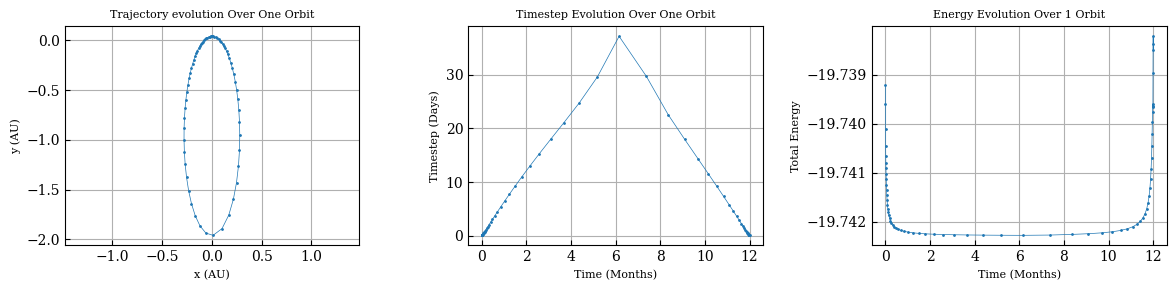

In [13]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))

#orbit trajectory
axs[0].plot(states_1[:, 0], states_1[:, 1], '.-',markersize=2,lw=0.5)
axs[0].set_xlabel('x (AU)',fontsize=8)
axs[0].set_ylabel('y (AU)',fontsize=8)
axs[0].set_title('Trajectory evolution Over One Orbit',fontsize=8)
axs[0].axis('equal')
axs[0].grid(True)

#evolution of the timestep over time
axs[1].plot(ts_1[:-1] * 12, taus_1 * 365, '.-',markersize=2,lw=0.5)
axs[1].set_xlabel('Time (Months)',fontsize=8)
axs[1].set_ylabel('Timestep (Days)',fontsize=8)
axs[1].set_title('Timestep Evolution Over One Orbit',fontsize=8)
axs[1].grid(True)

#energy evolution over 1 orbit
axs[2].plot(ts_1 * 12, energies_1, '.-',markersize=2,lw=0.5)
axs[2].set_xlabel('Time (Months)',fontsize=8)
axs[2].set_ylabel('Total Energy',fontsize=8)
axs[2].set_title('Energy Evolution Over 1 Orbit',fontsize=8)
axs[2].grid(True)
plt.tight_layout()
plt.show()

In [14]:
print("One Orbit:")
print("Number of timesteps:", len(taus_1))
print("Absolute Energy Error: {:.2e}".format(abs(energies_1[-1] - energies_1[0])))
print()

One Orbit:
Number of timesteps: 66
Absolute Energy Error: 7.16e-04



In [15]:
#25 orbits
ts_25, states_25, taus_25, errors_25 = adaptive_integrate_orbit(kepler, y0_ecc, 0, 25, tau_initial, error_goal)
energies_25 = np.array([energy(s) for s in states_25])

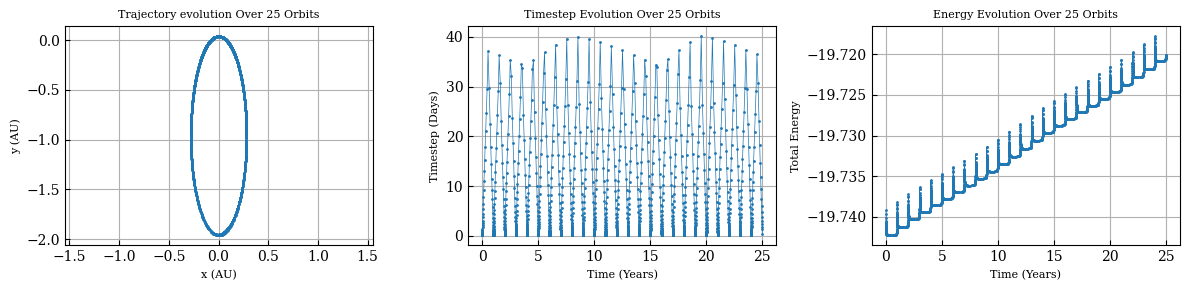

In [16]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))

#orbit trajectory
axs[0].plot(states_25[:, 0], states_25[:, 1], '.-',markersize=2,lw=0.5)
axs[0].set_xlabel('x (AU)',fontsize=8)
axs[0].set_ylabel('y (AU)',fontsize=8)
axs[0].set_title('Trajectory evolution Over 25 Orbits',fontsize=8)
axs[0].axis('equal')
axs[0].grid(True)

#evolution of the timestep over time
axs[1].plot(ts_25[:-1], taus_25 * 365, '.-',markersize=2,lw=0.5)
axs[1].set_xlabel('Time (Years)',fontsize=8)
axs[1].set_ylabel('Timestep (Days)',fontsize=8)
axs[1].set_title('Timestep Evolution Over 25 Orbits',fontsize=8)
axs[1].grid(True)

#energy evolution over 1 orbit
axs[2].plot(ts_25, energies_25, '.-',markersize=2,lw=0.5)
axs[2].set_xlabel('Time (Years)',fontsize=8)
axs[2].set_ylabel('Total Energy',fontsize=8)
axs[2].set_title('Energy Evolution Over 25 Orbits',fontsize=8)
axs[2].grid(True)
plt.tight_layout()
plt.show()

In [17]:
print("25 Orbits:")
print("Number of timesteps:", len(taus_25))
print("Absolute Energy Error: {:.2e}".format(abs(energies_25[-1] - energies_25[0])))

25 Orbits:
Number of timesteps: 1614
Absolute Energy Error: 1.92e-02




## Thoughts

Adaptive RK4 approach seems efficient but not on astronomical timescales (age of the solar system), I did this for 2000 orbits and the orbit already started to drift from its original position significantly. But for an order of 1e2 years, this should be a good approach. It's also interesting (yet intuitive), that energy conservation is really an issue only when the planet is moving faster.
